# Perceptron - Exo 4.3- CORRIGÉ

(dans l'esprit du notebook vu en CM `CM3*/démo de cours-Perceptron-amélioré.ipynb`

## Objectifs du TP:

A grand traits, voici les objectifs du TP (ensuite, suivez les questions, c'est assez guidé en fait):
- on va tenter de trouver un plan (droite) qui sépare 2 nuages de points, en 2D. Cela aide a débugger le code car on peut visualiser l'évolution du plan qui correspond au modèle, au fur et à mesure des itérations de la descente de gradient.
- **implémenter l'algorithme du peceptron** (c.a.d. la fonction `.fit()` qui correspond à ce modèle de classification binaire par un hyperplan). 
- Y ajouter du suivi: mesurer et stocker des métriques de performance (ici typiquement la fonction cout (Loss) et le taux d'erreur) pour l'ensemble d'entrainement et l'ensemble de validation. Puis les tracer
- si le temps le permet, utiliser votre algorithme sur mini-MNIST, un jeu de données qui représente des images de chiffres tracés à la main et ensuite numérisés. On se placera dans le cas binaire, donc on classifiera par exemple seulement les 0 et les 1. Si votre code est bien écrit, le passage du nuage de points en 2D a des images en 8x8 pixels ne pose aucun problème (évidemment on ne peut plus visualiser le plan de séparation car il y a trop de dimensions)

Ce TP est l'occasion d'apprendre a vectoriser les boucles avec numpy (utiliser des opération sur des `np.array` plutot que des boucles python).

## 0. Création de données en 2D et visualisation de la droite caractérisée par `w`

#### Remarque:
Dans cette partie vous n'avez rien a coder, juste a executer les cellules et inspecter un peu ce que fait le code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
#################
## squelette fourni dans TP4-mes_fonctions.py :
#################
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_blobs(N):
    # data set 3
    N1=N//4
    N2=N-N1
    D=2
    np.random.seed(42)

    # parameters for the 1st blob of points
    mu1=(0.3,0.3)
    sigma1=((1, 0.3))
    X1 = np.random.normal( mu1, sigma1,(N1,D))

    # parameters for the 2nd blob of points
    mu2=(-2,-2)
    sigma2=((2, 0.5))
    X2 = np.random.normal( mu2, sigma2,(N2,D))

    # the two blobs are merged, and labels  +1/-1  are assigned
    Xraw = np.concatenate( (X1, X2) )
    Y = np.concatenate( (np.ones(N1), -np.ones(N2)) ) # .reshape(N,1)
    X = Xraw.copy() # then X will be the extended vector, with the ones added

    X =  np.hstack((np.ones((N,1)), X))  # extended vector

    return X,Y


def display(X, Y, wInit, iteration, verbose=True):
    # cette fonction etait anciennement obtenue en faisant le TD2/3,
    # dans lequel on calculait la distance plan-droite,
    # et on apprenait a maitriser la relation géométrie / vecteurs
    def norme(wprime):
        return np.linalg.norm(wprime)
    
    w=wInit.copy()
    w0= w[0] # c'est la partie qui caractérise la distance à l'origine, qui détermine l'ordonnée à l'origine (mais ce n'est pas égal à ça)
    ## on normalise les composantes du vrai vecteur w
    wprime = w[1:] # /(w[1]**2+w[2]**2)**0.5
    if verbose:
        print(w, w0, wprime)

    u_w = (wprime/norme(wprime)) # vecteur unitaire donnant la direction
    distance_origine_droite = -w0/norme(wprime)
    projete_de_Origine_sur_droite = u_w * distance_origine_droite
    if verbose:
        print("projete_de_Origine_sur_droite", projete_de_Origine_sur_droite)

    vecteur_Orthogonal_A_La_Droite = np.array([wprime[1],-wprime[0]])
    extremite1 = projete_de_Origine_sur_droite + vecteur_Orthogonal_A_La_Droite*10
    extremite2 = projete_de_Origine_sur_droite - vecteur_Orthogonal_A_La_Droite*10
    extremites_abscisses = np.array([extremite1[0], extremite2[0]])
    extremites_ordonnees = np.array([extremite1[1], extremite2[1]])

    plt.figure(1)
    Class1 = X[Y==-1,1:] # points of class "-1"
    Class2 = X[Y== 1,1:] # points of class "+1"
    plt.plot(Class1[:,0], Class1[:,1], 'r+') # points of class "-1"
    plt.plot(Class2[:,0], Class2[:,1], 'bx') # points of class "+1"
    cmap = cm.jet
    colorGradient=cmap(np.linspace(0.0,1.0,12))
    plt.plot(extremites_abscisses, extremites_ordonnees,  color=colorGradient[iteration%(len(colorGradient))])
    if verbose:
        print(extremites_abscisses)
    
    

In [3]:
N=100
X, Y = make_blobs(100)


[1.   0.01 1.  ] 1.0 [0.01 1.  ]
projete_de_Origine_sur_droite [-0.009999   -0.99990001]
[  9.990001 -10.009999]


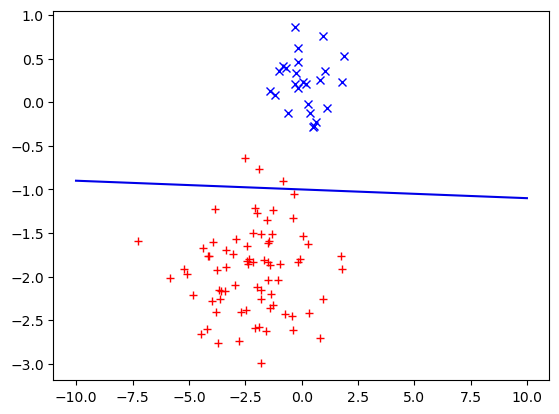

In [4]:
w0 = np.array([1,0.01,1])  ## w initial fixé, juste pour afficher une droite
display(X,Y, w0, 1)


### Remarque: 
Les données sont déja augmentées:  (on a mis "le 1")

In [5]:
X[:10]

array([[ 1.        ,  0.79671415,  0.25852071],
       [ 1.        ,  0.94768854,  0.75690896],
       [ 1.        ,  0.06584663,  0.22975891],
       [ 1.        ,  1.87921282,  0.53023042],
       [ 1.        , -0.16947439,  0.46276801],
       [ 1.        , -0.16341769,  0.16028107],
       [ 1.        ,  0.54196227, -0.27398407],
       [ 1.        , -1.42491783,  0.13131374],
       [ 1.        , -0.71283112,  0.3942742 ],
       [ 1.        , -0.60802408, -0.12369111]])

## 1. Initialisation des poids

- faites un choix pour la valeur initiale de `wparameters`, c.a.d donnez une valeur à $\vec w_0=$ `w0`. Idéalement, on les génère au hasard, par exemple avec une dsitribution Gaussienne, **centrée en 0**, d'écart type $1/\sqrt{D}$ (si votre écaert type est de 1, ça va aussi).
- choisissez des valeurs pour les hyper-parametres `eta`, `MaxIter`


In [6]:
X.shape

(100, 3)

In [7]:
X.shape[1]

3

In [8]:
np.random.normal(0,1, (10,3))

array([[ 0.35778736,  0.56078453,  1.08305124],
       [ 1.05380205, -1.37766937, -0.93782504],
       [ 0.51503527,  0.51378595,  0.51504769],
       [ 3.85273149,  0.57089051,  1.13556564],
       [ 0.95400176,  0.65139125, -0.31526924],
       [ 0.75896922, -0.77282521, -0.23681861],
       [-0.48536355,  0.08187414,  2.31465857],
       [-1.86726519,  0.68626019, -1.61271587],
       [-0.47193187,  1.0889506 ,  0.06428002],
       [-1.07774478, -0.71530371,  0.67959775]])

In [9]:
## TODO: créer une fonction qui inialise les poids
## (soit aléatoirement, soit de façon pré-fixée (c'est moins bien))
def initializeWeights(X, type):  # on ne regarde X que pour produire un w de la bonne dimension D.
    D= X.shape[1] ## quelle est la dimension des données ?
    wparameters = np.random.normal(loc=0,\
                                   scale=1/D**0.5,
                                   size=D)
    return wparameters


In [10]:
w0

array([1.  , 0.01, 1.  ])

[ 0.14860992 -0.524512   -0.21852887]
[ 0.14860992 -0.524512   -0.21852887] 0.1486099161871483 [-0.524512   -0.21852887]
projete_de_Origine_sur_droite [0.24142298 0.10058472]
[-1.94386572  2.42671168]


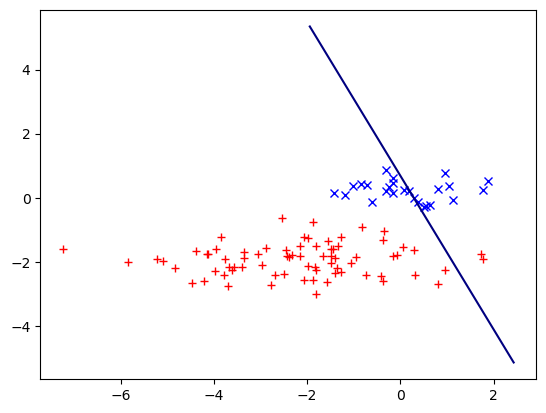

In [11]:
######### initialization of the separating vector ######
np.random.seed(43)
w0 = initializeWeights(X,"random")  ## w initial
print(w0)
display(X,Y, w0, 0)

### Remarque: 
On a copié-collé le contenu du squelette fourni (les fonctions du fichier `mes_fonctions.py`) dans des cellules de ce jupyter-notebook, et on peut travailler directement ici. Ou alors on peut travailler dans `mes_fonctions.py` et exécuter le code ci dessous, typiquement, si on veut apprendre a écrire des modules séparés du `main`

In [12]:
%load_ext autoreload
%autoreload 2
# import mes_fonctions
## autoreload permet de modifier le fichier mes_fonctions sans avoir à le re-importer après chaque changement

In [13]:
## intulie de faire tourner ceci si vous codez directment dans le notebook (== ce fichier)
# mes_fonctions.initializeWeights(X, "random") 

In [14]:
### hyper-parametres ###
MAXITER = 100
eta = 0.01

## 2. Implémentation de l'algorithme du perceptron

### 2.1 Implémentations minimales

#### Remarque:
en gros, ça revient juste à écrire le code trouvé dans l'exo 4.1 (**corrigé dans** `Correction du 4.1 -- pseudo code du perceptron.pdf`), en utilisant:
- soit la version naïve, avec des boucles `Algorithm 3`, 
- soit la version plus numpy-esque (qui est moins triviale à lire et à coder, mais environ 100x plus rapide a éxécuter), `Algorithm 4`.

In [15]:
## au début ne vous occupez pas de ça:
plotting = False
verbose = False

In [16]:
a= np.random.randint(0,10,5 )
a

array([1, 2, 7, 0, 3])

In [17]:
b = a>5
b

array([False, False,  True, False, False])

In [18]:
a[b]

array([7])

In [19]:
a@b, np.dot(a,b), a*b, a+b, a-b

(7, 7, array([0, 0, 7, 0, 0]), array([1, 2, 8, 0, 3]), array([1, 2, 6, 0, 3]))

In [20]:
n=23
print(X.shape, Y.shape)

(100, 3) (100,)


In [21]:
np.dot(X[n],w0), X[n]@w0

(0.09800470041330764, 0.09800470041330764)

In [22]:
X[n]@w0 * Y[n] <= 0

False

In [23]:
## TODO: remplir cette fonction (au moins, sans les affichages
## mais de sorte que le résultat soit correct)
def perceptronFullBatch_version_minimale(X,Y,eta, w0, maxIter=20, plot=None, verbose=None, Loss=None):
    w = w0.copy()
    for itera in range(maxIter):
        ListeDesMalClasses = []
        N = X.shape[0]
        for n in range(N):
            if X[n]@w * Y[n] <= 0:
                ListeDesMalClasses.append(n)
        if len(ListeDesMalClasses) == 0:
            return w
        for n in ListeDesMalClasses:
            w = w + eta*1/N * X[n] * Y[n]
    return w

In [24]:
### hyper-parameters ###
MAXITER=185
eta = 0.05
## on lance le calcul
w =  perceptronFullBatch_version_minimale(X,Y,eta, w0, MAXITER, plotting, verbose)

In [25]:
## voyons si ça a bien marché, visuellement:
display(X,Y, w0, 0)
display(X,Y, w, 3)

[ 0.14860992 -0.524512   -0.21852887] 0.1486099161871483 [-0.524512   -0.21852887]
projete_de_Origine_sur_droite [0.24142298 0.10058472]
[-1.94386572  2.42671168]
[0.03860992 0.00238232 0.13678259] 0.03860991618714821 [0.00238232 0.13678259]
projete_de_Origine_sur_droite [-0.00491479 -0.28218655]
[ 1.36291113 -1.37274071]


In [26]:
ListeDesMalClasses = ((X@w0) * Y <= 0 )
w = w + eta*1/N*X[ListeDesMalClasses].T @ Y[ListeDesMalClasses]


In [27]:
ListeDesMalClasses.sum()

83

In [28]:
## TODO: remplir cette fonction (au moins, sans les affichages
## mais de sorte que le résultat soit correct)
def perceptronFullBatch_version_minimale(X,Y,eta, w0, maxIter=20, plot=None, verbose=None, Loss=None):
    w = w0.copy()
    for itera in range(maxIter):
        ListeDesMalClasses = ((X@w) * Y <= 0 )
        if ListeDesMalClasses.sum() == 0 :
            return w
        w = w + eta*1/N*X[ListeDesMalClasses].T @ Y[ListeDesMalClasses]
    return w

In [29]:
### hyper-parameters ###
MAXITER=185
eta = 0.05
## on lance le calcul
w =  perceptronFullBatch_version_minimale(X,Y,eta, w0, MAXITER, plotting, verbose)

In [30]:
## voyons si ça a bien marché, visuellement:
display(X,Y, w0, 0)
display(X,Y, w, 3)

[ 0.14860992 -0.524512   -0.21852887] 0.1486099161871483 [-0.524512   -0.21852887]
projete_de_Origine_sur_droite [0.24142298 0.10058472]
[-1.94386572  2.42671168]
[0.03860992 0.00238232 0.13678259] 0.03860991618714821 [0.00238232 0.13678259]
projete_de_Origine_sur_droite [-0.00491479 -0.28218655]
[ 1.36291113 -1.37274071]


### 2.2 Implémentation avec suivi 

#### Quand votre code "minimaliste" converge, ou bien même si il compile sans converger, et que vous voulez comprendre pourquoi:

Faites une version plus avancée `perceptronFullBatch_version_decoree`, dans laquelle vous réalisez:
- un découpage (*split*) des données (train/validation) à partir de vos données d'entrainement. Vous pouvez utiliser `sklearn.model_selection.train_test_split`
- un calcul du taux d'erreur (sur l'ensemble d'entrainement)
- un calcul du taux d'erreur (sur l'ensemble de validation)
- un calcul de la fonction cout (sur l'ensemble d'entrainement)
- un calcul de la fonction cout (sur l'ensemble de validation)
- un affichage de l'hyperplan de séparation, à l'aide de la fonction display, qui est fournie (option controlée par le paramètre booleen `plotting`)

In [31]:
import sklearn.model_selection

## full correction, with monitoring, displays, additional exit criterion, etc
def perceptronFullBatch_version_decoree(Xinput, Yinput,eta, w0, maxIter=20, plot=True, verbose=True, Loss="ReLU"):
    
    X, X_valid, Y, Y_valid = sklearn.model_selection.train_test_split(Xinput, Yinput, test_size=0.3, random_state=42)
    N = X.shape[0]
    D = X.shape[1]
    w = w0.copy()  # deep copy
    suiviNbErreurs_ensemble_entrainement    = np.zeros(maxIter)
    suiviNbErreurs_ensemble_validation      = np.zeros(maxIter)
    suiviFonctionCout_ensemble_entrainement = np.zeros(maxIter)
    suiviFonctionCout_ensemble_validation   = np.zeros(maxIter)
    
    err_train, err_val, loss_train, loss_val = suiviNbErreurs_ensemble_entrainement   ,     suiviNbErreurs_ensemble_validation     ,     suiviFonctionCout_ensemble_entrainement,     suiviFonctionCout_ensemble_validation  
    
    ## the algo itself ##
    for iteration in range(maxIter):
        ## we look for misclassified examples ##
        modelValues = X @ w
        XwT = (modelValues)*Y          #  This is   (X @ w * Y)
        misClassified = (XwT <= 0) ## array of booleans (used as a mask or filter)
        misClassifiedNumber = misClassified.sum()  ## True~1, False~0,so by summing up, we count the True's
        if misClassifiedNumber == 0:
            print("Convergence at iteration", iteration)
            if plot :
                display(X,Y, w, iteration)
            print(w)
            return w, err_train, err_val, loss_train, loss_val
        else: ## updating parameters ##

            #  Rosenblatt style, but full batch:
            w -= -eta/N * (Y[misClassified]@X[misClassified])

            if verbose==True:
                print("iteration #",iteration," there are " , misClassifiedNumber, 'misclassified points => new vector', w)
        if plot :
            display(X,Y, w, iteration, verbose)
            
        ## logging of error numbers and cost function value over epochs (GD iterations)
        misClassified_train=  ((X       @ w)*Y        <= 0)
        misClassified_valid = ((X_valid @ w)*Y_valid  <= 0)
        suiviNbErreurs_ensemble_entrainement    [iteration] = misClassified_train.mean() ## == misClassifiedNumber
        suiviNbErreurs_ensemble_validation      [iteration] = misClassified_valid.mean()
        suiviFonctionCout_ensemble_entrainement [iteration] = 1/N*np.sum( -X      [misClassified_train]@ w * Y      [misClassified_train])
        suiviFonctionCout_ensemble_validation   [iteration] = 1/N*np.sum( -X_valid[misClassified_valid]@ w * Y_valid[misClassified_valid])


    print("No convergence after", maxIter, "iterations.\nThere were misClassifiedNumber*100/N=",misClassifiedNumber/N*100, "% misclassified data points.")
    err_train, err_val, loss_train, loss_val = suiviNbErreurs_ensemble_entrainement   ,     suiviNbErreurs_ensemble_validation     ,     suiviFonctionCout_ensemble_entrainement,     suiviFonctionCout_ensemble_validation  
    return w, err_train, err_val, loss_train, loss_val


In [32]:
plotting = True
verbose = False

In [33]:
### hyper-parameters ###
MAXITER=85
eta = 0.05
## on lance le calcul
w, err_train, err_val, loss_train, loss_val =  perceptronFullBatch_version_decoree(X,Y,eta, w0, MAXITER, plotting, verbose)


Convergence at iteration 29
[ 0.03789563 -0.0008603   0.13542555] 0.0378956304728626 [-0.0008603   0.13542555]
projete_de_Origine_sur_droite [ 0.00177755 -0.27981502]
[ 1.35603301 -1.35247791]
[ 0.03789563 -0.0008603   0.13542555]


In [34]:
plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')
plt.plot(loss_train, label = 'loss_train')
plt.plot(loss_val, label = 'loss_val')
plt.semilogy()
plt.legend()

#### On corse un peu la chose pour avoir des plots moins triviaux:

In [35]:
## il suffit de mettre plus de points .. !
N=1000
X, Y = make_blobs(N)

In [36]:
### hyper-parameters ###
MAXITER=85
eta = 0.05
## on lance le calcul
w, err_train, err_val, loss_train, loss_val =  perceptronFullBatch_version_decoree(X,Y,eta, w0, MAXITER, plotting, verbose)


No convergence after 85 iterations.
There were misClassifiedNumber*100/N= 0.14285714285714285 % misclassified data points.


In [37]:
plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')
plt.plot(loss_train, label = 'loss_train')
plt.plot(loss_val, label = 'loss_val')
plt.semilogy()
plt.legend()

## 3. Application sur données réelles

### 3.1 Application sur mini-MNIST

#### On teste sur des "vraies" données (en fait, c'est encore un très petit jeu de données)

In [38]:
import sklearn.datasets
import sklearn.model_selection

#### Load_digits (mini-MNIST, en taille 8x8, avec seulement ~2000 exemples)

Remarque: Le MNIST complet en contient 70000, chacun de taille 28x28. Allez voir https://gitlab.inria.fr/flandes/data-for-teaching/-/blob/master/import-mnist70-numpy-npz.py si vous voulez charger mon fichier https://gitlab.inria.fr/flandes/data-for-teaching/-/blob/master/mnist70.npz

In [39]:

X, Y = sklearn.datasets.load_digits(n_class=2, return_X_y=True)

## on fait immédiatement l'astuce du 1 (augmentation de toutes les données par ajout d'une colonne de 1)
N = X.shape[0]
X =  np.hstack((np.ones((N,1)), X))  # extended vector

## on encode le label "Ground Truth" (vrai) dans les valeurs {-1,1} plutot que {0,1}
Y*=2
Y -= 1

## on coupe et on réserve 20% des data pour le test final 
X, X_test, Y, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [40]:
Y

array([-1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,
       -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1,
        1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1, -1,  1,
        1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,
        1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,
       -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1,
        1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1, -1,  1,  1

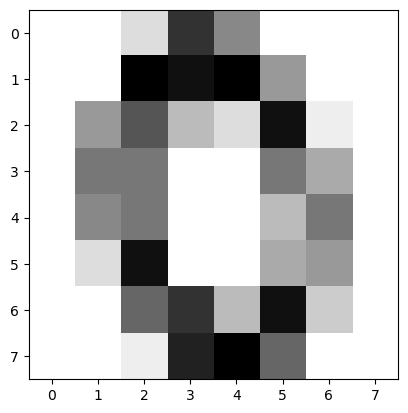

In [41]:
## la premiere image est un zero:
plt.imshow(X[0,1:].reshape(8, 8), cmap=plt.cm.binary)

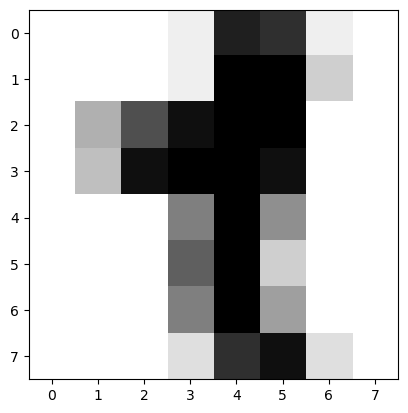

In [42]:
## la 45ème image est un 1:
plt.imshow(X[44,1:].reshape(8, 8), cmap=plt.cm.binary)

In [43]:
### hyper-parameters ###
MAXITER=500
eta = 0.001
## on lance le calcul
plotting=False
verbose=False

## on initialise w avec la bonne dimension (ceci pourrait/devrait etre fait dans la fonction de fit, en fait)
np.random.seed(12)
w0 = initializeWeights(X, "random")

w =  perceptronFullBatch_version_minimale(X,Y,eta, w0, MAXITER, plotting, verbose)


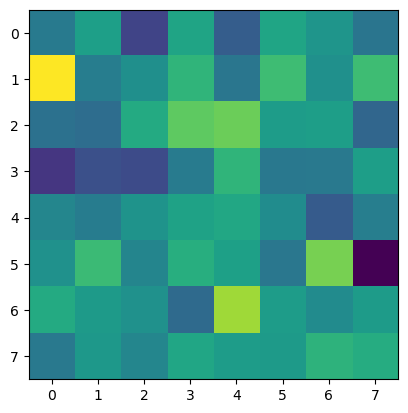

In [44]:
## pour de plus gros dataset, moins triviaux, on peut plus ou moins voir les 2 images types, si on affiche 
## le vecteur des parametres w (ça demande qq explications, posez la question en CM!)
plt.imshow(w[1:].reshape(8,8))

No convergence after 200 iterations.
There were misClassifiedNumber*100/N= 3.482587064676617 % misclassified data points.


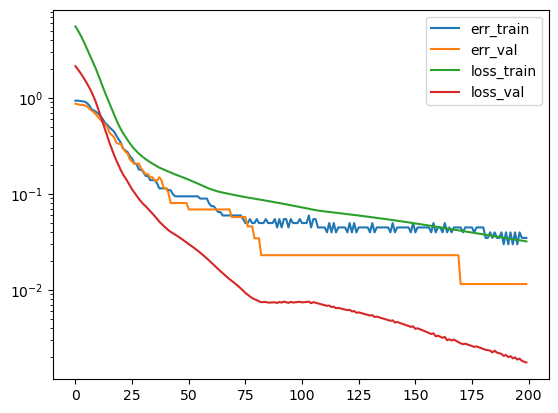

In [45]:
### hyper-parameters ###
MAXITER=200
eta = 0.001
## on lance le calcul
plotting=False
verbose=False

## on initialise w avec la bonne dimension (ceci pourrait/devrait etre fait dans la fonction de fit, en fait)
np.random.seed(12)
w0 = initializeWeights(X, "random")

w, err_train, err_val, loss_train, loss_val =  perceptronFullBatch_version_decoree(X,Y,eta, w0, MAXITER, plotting, verbose)

plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')
plt.plot(loss_train, label = 'loss_train')
plt.plot(loss_val, label = 'loss_val')
plt.semilogy()
plt.legend()

### À tester: essayer de varier la graine, c.a.d. 
`np.random.seed(12)` : rempalcer par `np.random.seed(1) `  (essayer plein de valeurs)

Et à chaque fois, observer le comportement des courbes. Intéressant, non?

### 3.2 Encore un test: sur le dataset des vins

In [46]:
import sklearn.datasets
X, Y = sklearn.datasets.load_wine(return_X_y=True)

## on filtre les vins qui ne sont pas d'une des deux premières classes
filtre = Y<2
X = X[filtre]
Y = Y[filtre]
## on fait immédiatement l'astuce du 1 (augmentation de toutes les données par ajout d'une colonne de 1)
N = X.shape[0]
X =  np.hstack((np.ones((N,1)), X))  # extended vector
## on encode le label "Ground Truth" (vrai) dans les valeurs {-1,1} plutot que {0,1}
Y*=2
Y-=1
## on coupe et on réserve 20% des data pour le test final 
X, X_test, Y, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [47]:
X.shape, Y.shape, X_test.shape

((104, 14), (104,), (26, 14))

No convergence after 200 iterations.
There were misClassifiedNumber*100/N= 8.333333333333332 % misclassified data points.


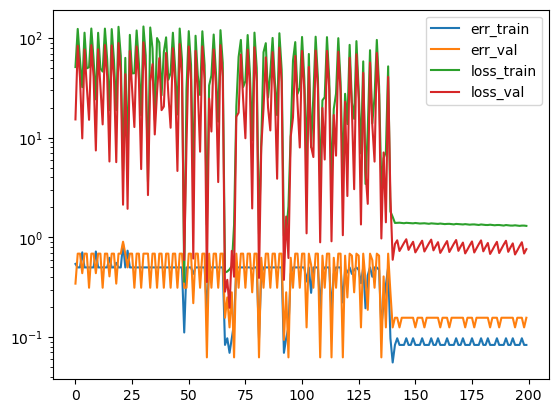

In [48]:
### hyper-parameters ###
MAXITER=200
eta = 0.001
## on lance le calcul
plotting=False
verbose=False

## on initialise w avec la bonne dimension (ceci pourrait/devrait etre fait dans la fonction de fit, en fait)
np.random.seed(1)
w0 = initializeWeights(X, "random")

w, err_train, err_val, loss_train, loss_val =  perceptronFullBatch_version_decoree(X,Y,eta, w0, MAXITER, plotting, verbose)

plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')
plt.plot(loss_train, label = 'loss_train')
plt.plot(loss_val, label = 'loss_val')
plt.semilogy()
plt.legend()

# TODO (à la maison - lors de votre projet): améliorer le choix des hyper-paramètres, et seulement à la fin de ce choix, tester sur le test set/
